In [2]:
import pandas as pd
import numpy as np
import helper_functions as hf
import pickle
import matplotlib.pyplot as plt
import importlib
import math
import copy
import re
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import random
importlib.reload(hf)
import warnings
warnings.filterwarnings('ignore')

In [ ]:


##########################################################################
##### Functions to propogate associations in decision trees  #############
##########################################################################

def getLeafInx(estimator):
    leaf_inx = np.where([i == -1 and j == -1 for i,j in zip(estimator.tree_.children_left, estimator.tree_.children_right)])
    return(leaf_inx[0])

def getLabels(estimator):
    value = estimator.tree_.value
    leaf_inx = getLeafInx(estimator)
    labels = []
    for val_set in value[leaf_inx]:
        val_set = np.squeeze(val_set)
        if val_set[0] > val_set[1]:
            val = "neg"
        else:
            val = "pos"
        labels.append(val)
    return(labels)

def associate_one_level(feature, label_left, label_right):
    associations[feature][label_right] += 1
    associations[feature][label_left] -= 1
    
def left_side_propogate(root, feature, label_left, label_right):
    if label_left == label_right:
        associations[root][label_left] -= 1 #Doesn't matter which label, they're equal
    else:
        associate_one_level(feature, label_left, label_right)

def right_side_propogate(root, feature, label_left, label_right):
    if label_left == label_right:
        associations[root][label_left] += 1
    else:
        associate_one_level(feature, label_left, label_right)

def getAssociation(associations, i):
    if associations[i]["pos"] > associations[i]["neg"]:
        return("pos")
    if associations[i]["pos"] == associations[i]["neg"]:
        return('EQ')
    else: 
        return("neg")
    
def getDiffMag(associations, i):
    return(associations[i]["pos"] - associations[i]["neg"])


def rankFeatureAssociations(m, feat_imp_df_paths, AG=False):
    #associations = {}

    estimators = m.estimators_
    i = 0
    for estimator in estimators:
        #print(i)
        features = estimator.tree_.feature + 1 # the forest starts labeling it's features at 0, we start at 1
        features = features[features > 0]
        labels = getLabels(estimator)
        leaf_inx = getLeafInx(estimator)
        op1 = [2, 3, 5, 6] #full set of nodes
        op2 = [2,3,4] #no test node right
        op3 = [1, 3, 4] # no test node left
        for feat in features:
            if not feat in associations:
                associations[feat] = {"pos": 0, "neg":0}

        if np.array_equal(leaf_inx , op1):
            left_side_propogate(features[0], features[1], labels[0], labels[1])
            right_side_propogate(features[0], features[2], labels[2], labels[3])

        if np.array_equal(leaf_inx , op2):
            left_side_propogate(features[0], features[1], labels[0], labels[1])
            associations[features[0]][labels[2]] += 1

        if np.array_equal(leaf_inx , op3):
            right_side_propogate(features[0], features[1], labels[1], labels[2])
            associations[features[0]][labels[0]] -= 1

        i += 1

        topics = [int(re.sub("property_100_", "", i)) for i in feat_imp_df_paths.index.values]
    
    association = np.array(['NA '] * len(topics))
    diffMag = np.zeros(len(topics))
    i = 0
    for topic in topics:
        if topic in associations.keys():
            association[i] = getAssociation(associations, topic)
            diffMag[i] = getDiffMag(associations, topic)
        else:
            association[i] = "NA"
        i += 1

    feat_imp_df_paths.insert(3, "Association", association)
    feat_imp_df_paths.insert(4, "Diff Num. Trees Associated", diffMag)
    return(feat_imp_df_paths)


## Read in Halfvarson data in embedded form, and mapping file

In [50]:
data_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/data/"
fig_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/figures/"

embedded = pd.read_csv(data_dir + "halfvarson/embed/seqtab_embedded_.07_100dim.txt", sep = "\t")
mapping = pd.read_csv(data_dir + "halfvarson/mapping.txt", sep = "\t", index_col = 0)
mapping['sample_name'] = mapping.index.values


mapping = mapping.loc[embedded.index.values, :]

##Check
np.sum(mapping.index.values == embedded.index.values) == mapping.shape[0] == embedded.shape[0]

True

In [59]:

qual_vecs, embed_ids, embed_seqs = hf.getQualVecs(data_dir)



otu = pd.read_csv(data_dir + "halfvarson/seqtab.txt", sep = "\t")
otu.shape

best_hits = pd.read_csv(data_dir + "halfvarson/embed/best_hits.tsv", header = None, sep = "\t")
best_hits.columns = ["query_id", "hit_id", "query_seq", "hit_seq", "evalue", "bitscore"]
best_hits = best_hits.set_index('query_id')
keep = [i < 1E-29 for i in best_hits['evalue'] ]
best_hits = best_hits.loc[keep, :]
print(best_hits.shape)
best_hits


#Get only those ASVs that have a match in the embedding set

best_hits = best_hits.loc[[i in otu.columns.values for i in best_hits['query_seq']], :]
otu_use = otu.loc[:, best_hits['query_seq'].values]

#Assign id of best match and reorder columns
otu_use.columns = best_hits.loc[:, 'hit_id']

#Put transformation matrix in order to be dotted with the ASV table
qual_vecs_half = qual_vecs.loc[otu_use.columns.values, :]

mapping['sample_name'] = mapping.index.values
mapping = mapping.loc[[i in otu_use.index.values for i in mapping.index.values], :]
otu_use = otu_use.loc[mapping.index, :]

26726
26726
(26726, 100)
(25159, 5)


In [ ]:
embedded_half = pd.DataFrame(np.dot(hf.asinh(otu_use), qual_vecs_half))
embedded_half.columns = qual_vecs_half.columns.values
embedded_half.index = otu_use.index.values

## Get cumulative associations across timepoints


In [74]:
pos_class = ["UC", "CD"]
neg_class = ["HC"]
classes = pos_class + neg_class

sample_ids_keep = mapping.index.values[[i in classes for i in mapping.diagnosis_full]]
embedded_half = embedded_half.loc[sample_ids_keep, :]
mapping_half = mapping.loc[sample_ids_keep, :]
y_half = [i in ["CD", "UC"] for i in mapping_half['diagnosis_full']]

#otu_half = otu_use
#embedded_half = pd.DataFrame(np.dot(hf.asinh(otu_use), qual_vecs_half))
#embedded_half.columns = qual_vecs_half.columns.values

#keep = [i in ["CD", "UC", "HC"] for i in mapping["diagnosis_full"].values]
#embedded_half = embedded_half.loc[keep, :]
#otu_half = otu_half.loc[keep, :]
#mapping_half = mapping.loc[keep, :]
#y_half = [i in ["CD", "UC"] for i in mapping_half['diagnosis_full']]

0
Embed
(608, 100)
0.6818181818181818
0.9483659648432375
1
Embed
(608, 100)
0.9444444444444444
0.9944444444444445
2
Embed
(608, 100)
0.875
0.9846850198412699
3
Embed
(608, 100)
0.6785714285714286
0.9522534013605441


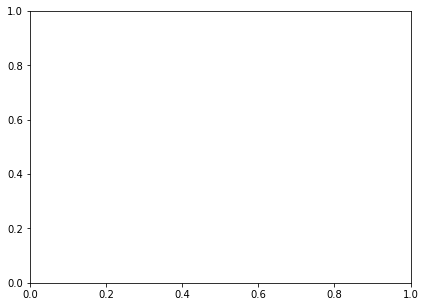

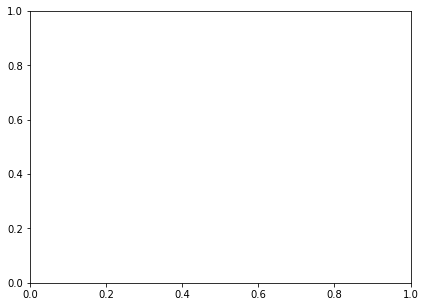

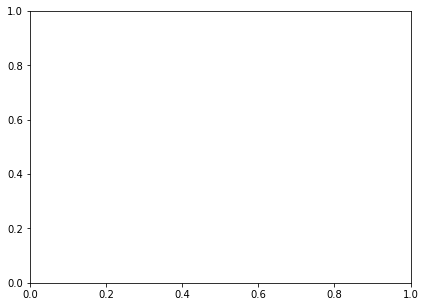

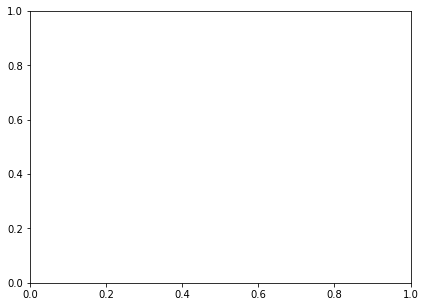

In [75]:

pathway_table = pd.read_csv(data_dir + "pathways/property_pathway_dict.txt",
                            sep= "\t", dtype= {"pathway_id": 'object'})
pathway_table = pathway_table.set_index('dim')

mapping_grouped = mapping_half.groupby('patientnumber')
feat_imp_timepoints = None

for timepoint in [0,1,2,3]:
    print(timepoint)
    map_onesample = mapping_grouped.nth(timepoint)
    embedded_use = embedded_half.loc[map_onesample['sample_name'], :]
    y = [i in pos_class for i in map_onesample['diagnosis_full'].values]
    np.sum(y)
    
    f = plt.figure(figsize=(15,5))
    auc_crossVal, auc_prec_crossVal, f1_crossVal, feat_imp_embed = hf.crossValPrediction(embedded_use, y, 
                                                                                         max_depth = 2, n_estimators = 50,  weight = 5,
                                                                                         folds = 4,
                                                                                        plot = False, plot_pr = False)
    print("Embed")
    print(embedded.shape)
    print(np.mean(auc_crossVal))
    print(np.mean(auc_prec_crossVal))
    

    feat_imp_df = hf.getFeatImpDf(feat_imp_embed)

    tmp = pathway_table.loc[feat_imp_df.index.values, :]
    feat_imp_df_paths = pd.merge(feat_imp_df, tmp, left_index = True, right_index = True)
    
    if timepoint == 0:
        feat_imp_timepoints = pd.DataFrame(feat_imp_df_paths)
        feat_imp_timepoints["cum_timepoint_importance"] = 0
        feat_imp_timepoints["cum_timepoint_numtrees"] = 0

    max_depth = 2
    n_estimators = 50
    weight = 20
    weights = {0:1, 1:weight}
    m = RandomForestClassifier(max_depth= max_depth, random_state=0, n_estimators=n_estimators, class_weight = weights)
    m.fit(embedded_use, y)
    
    associations = {}
    tmp = rankFeatureAssociations(m, feat_imp_df_paths)
    for prop in tmp.index.values:
        feat_imp_timepoints.loc[prop, "cum_timepoint_importance"] += tmp.loc[prop, "cum_importance"]
        feat_imp_timepoints.loc[prop, "cum_timepoint_numtrees"] += tmp.loc[prop, 'Diff Num. Trees Associated']

In [76]:
labels = []
for prop in feat_imp_timepoints.index.values:
    val = feat_imp_timepoints.loc[prop, 'cum_timepoint_numtrees']
    if val < 0:
        labels.append(str(neg_class))
    elif val > 0:
        labels.append(str(pos_class))
    else:
        labels.append("NA")
feat_imp_timepoints["Association"] = labels
feat_imp_timepoints = feat_imp_timepoints.drop('Diff Num. Trees Associated', axis = 1)

In [77]:
feat_imp_timepoints = feat_imp_timepoints.sort_values("cum_timepoint_importance", ascending = False)
feat_imp_timepoints = feat_imp_timepoints.drop("cum_importance", axis = 1)
feat_imp_timepoints['pathway_id'] = [re.sub("^", "ko", str(i)) for i in feat_imp_timepoints['pathway_id'].values]
feat_imp_timepoints.to_csv("../data/halfvarson/metabolic_pathways_importance_half_2.csv")

In [78]:
feat_imp_timepoints

,pathway_id,pathway_names,Association,cum_timepoint_importance,cum_timepoint_numtrees
property_100_57,ko00540,Lipopolysaccharide biosynthesis,['HC'],1.163191,-42.0
property_100_98,ko00362,Benzoate degradation,"['UC', 'CD']",0.975997,34.0
property_100_43,ko00100,Steroid biosynthesis,"['UC', 'CD']",0.657086,19.0
property_100_25,ko00380,Tryptophan metabolism,['HC'],0.639043,-13.0
property_100_1,ko00281,Geraniol degradation,['HC'],0.637752,-18.0
property_100_97,ko05150,Staphylococcus aureus infection,"['UC', 'CD']",0.447894,13.0
property_100_100,ko00930,Caprolactam degradation,['HC'],0.443508,-18.0
property_100_38,ko00910,Nitrogen metabolism,['HC'],0.420892,-12.0
property_100_21,ko00360,Phenylalanine metabolism,"['UC', 'CD']",0.401770,14.0
property_100_48,ko00480,Glutathione metabolism,"['UC', 'CD']",0.371858,10.0


## Run the same cross-validation importance of features tests on AG data

In [79]:
data_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/data/"
fig_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/figures/"


#Load data
filt = ".07"
f = open(data_dir + "AG_new/filter_.07//otu_train_" + str(filt) + ".obj", "rb")
otu_train_ag = pickle.load(f)
f.close()

f = open(data_dir + "AG_new/filter_.07//otu_test_" + str(filt) + ".obj", "rb")
otu_test_ag = pickle.load(f)
f.close()

f = open("C:/Users/ctata/Documents/Lab/quality_vectors/data/AG_new/feces/map_train_strictDiag.obj", "rb")
map_train_ag = pickle.load(f)
f.close()

f = open("C:/Users/ctata/Documents/Lab/quality_vectors/data/AG_new/feces/map_test_strictDiag.obj", "rb")
map_test_ag = pickle.load(f)
f.close()

qual_vecs, embed_ids, embed_seqs = hf.getQualVecs(data_dir)

otu_train_ag = hf.matchOtuQual(otu_train_ag, qual_vecs.index.values, embed_seqs)
otu_test_ag = hf.matchOtuQual(otu_test_ag, qual_vecs.index.values, embed_seqs)

data_ag = pd.concat([otu_train_ag, otu_test_ag])
mapping_ag = pd.concat([map_train_ag, map_test_ag])
embedded_ag = pd.DataFrame(np.dot(hf.asinh(data_ag), qual_vecs))
embedded_ag.columns = qual_vecs.columns.values
y_ag = mapping_ag["IBD"].values

26726
26726
(26726, 100)
all good
all good


0.7709489387047868
0.37871752686629473
0.8361487050960734
0.49437597426068436
0.7294863516162332
0.48559334575779023
0.6466609742804817
0.35245797486190683


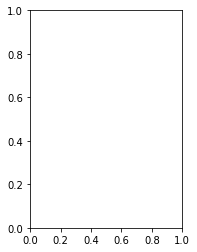

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
pathway_table = pd.read_csv(data_dir + "pathways/property_pathway_dict_2.txt",
                            sep= "\t", dtype= {"pathway_id": 'object'})
pathway_table = pathway_table.set_index('dim')
    
importlib.reload(hf)
target = "IBD"

kf = StratifiedShuffleSplit(n_splits = 4)
kf.get_n_splits(embedded_ag, y_ag)
i = 0

feat_imp_timepoints_ag = None
for train_index, val_index in kf.split(embedded_ag, y_ag):
    embedded_tmp = embedded_ag.iloc[val_index, :]
    y_tmp = y_ag[val_index]
    auc_crossVal, auc_prec_crossVal, f1_crossVal, feat_imp_embed = hf.crossValPrediction(embedded_tmp, y_tmp,
                                                                                         max_depth = 2, n_estimators = 50,  weight = 20,
                                                                                        plot= False, plot_pr = False)
    print(np.mean(auc_crossVal))
    print(np.mean(auc_prec_crossVal))



    feat_imp_df = hf.getFeatImpDf(feat_imp_embed)


    tmp = pathway_table.loc[feat_imp_df.index.values, :]
    feat_imp_df_paths = pd.merge(feat_imp_df, tmp, left_index = True, right_index = True)
    
    if i == 0:
        feat_imp_timepoints_ag = pd.DataFrame(feat_imp_df_paths)
        feat_imp_timepoints_ag["cum_timepoint_importance"] = 0
        feat_imp_timepoints_ag["cum_timepoint_numtrees"] = 0


    max_depth = 2
    n_estimators = 50
    weight = 20
    weights = {0:1, 1:weight}
    m = RandomForestClassifier(max_depth= max_depth, random_state=0, n_estimators=n_estimators, class_weight = weights)
    m.fit(embedded_tmp, y_tmp)

    associations = {}
    tmp = rankFeatureAssociations(m, feat_imp_df_paths)
    for prop in tmp.index.values:
        feat_imp_timepoints_ag.loc[prop, "cum_timepoint_importance"] += tmp.loc[prop, "cum_importance"]
        feat_imp_timepoints_ag.loc[prop, "cum_timepoint_numtrees"] += tmp.loc[prop, 'Diff Num. Trees Associated']
    i += 1

In [14]:
labels = []
for prop in feat_imp_timepoints_ag.index.values:
    val = feat_imp_timepoints_ag.loc[prop, 'cum_timepoint_numtrees']
    if val < 0:
        labels.append(str(neg_class))
    elif val > 0:
        labels.append(str(pos_class))
    else:
        labels.append("NA")
feat_imp_timepoints_ag["Association"] = labels


In [15]:
feat_imp_timepoints_ag = feat_imp_timepoints_ag.drop('Diff Num. Trees Associated', axis = 1)
feat_imp_timepoints_ag = feat_imp_timepoints_ag.drop("cum_importance", axis = 1)
feat_imp_timepoints_ag['pathway_id'] = [re.sub("^", "ko", str(i)) for i in feat_imp_timepoints_ag['pathway_id'].values]

In [16]:
feat_imp_timepoints_ag= feat_imp_timepoints_ag.sort_values('cum_timepoint_importance', ascending = False)
feat_imp_timepoints_ag.to_csv("../data/AG_new/metabolic_pathways_importance_ag_2.csv")

In [17]:
feat_imp_timepoints_ag

,pathway_id,pathway_names,Association,cum_timepoint_importance,cum_timepoint_numtrees
property_100_12,ko00523,Polyketide sugar unit biosynthesis,"['UC', 'CD']",0.873383,16.0
property_100_77,ko00310,Lysine degradation,['HC'],0.843022,-6.0
property_100_76,ko00591,Linoleic acid metabolism,['HC'],0.839683,-12.0
property_100_44,ko00332,Carbapenem biosynthesis,"['UC', 'CD']",0.737138,12.0
property_100_61,ko00625,Chloroalkane and chloroalkene degradation,['HC'],0.633789,-9.0
property_100_8,ko00626,Naphthalene degradation,['HC'],0.524479,-12.0
property_100_28,ko02026,Biofilm formation - Escherichia coli,['HC'],0.472113,-4.0
property_100_57,ko00540,Lipopolysaccharide biosynthesis,['HC'],0.457129,-10.0
property_100_27,ko00998,Biosynthesis of secondary metabolites - other ...,"['UC', 'CD']",0.442930,11.0
property_100_93,ko00480,Glutathione metabolism,"['UC', 'CD']",0.439803,6.0
